## Module 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_names = [
    'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
    'Sub_metering_3'
]

data = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    names=column_names,
    header=None,
    skiprows=1,
    encoding='latin1',
    engine='python'
)
print(data.head())
print(data.shape)



         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
(1172919, 9)


In [ ]:
print(data.info())
print(data.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172919 entries, 0 to 1172918
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1172919 non-null  object 
 1   Time                   1172919 non-null  object 
 2   Global_active_power    1168783 non-null  float64
 3   Global_reactive_power  1168783 non-null  float64
 4   Voltage                1168783 non-null  float64
 5   Global_intensity       1168783 non-null  float64
 6   Sub_metering_1         1168783 non-null  float64
 7   Sub_metering_2         1168783 non-null  float64
 8   Sub_metering_3         1168783 non-null  float64
dtypes: float64(7), object(2)
memory usage: 80.5+ MB
None
             Date      Time  Global_active_power  Global_reactive_power  \
count     1172919   1172919         1.168783e+06           1.168783e+06   
unique        816      1440                  NaN                    NaN   
top     22/

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0              18.4             0.0             1.0            17.0   
1              23.0             0.0             1.0            16.0   
2              23.0             0.0             2.0            17.0   
3              23.0             0.0             1.0            17.0   
4              15.8             0.0             1.0            17.0   

             Datetime  
0 2006-12-16 17:24:00  
1 2006-12-16 17:25:00  
2 2006-12-16 17:26:0

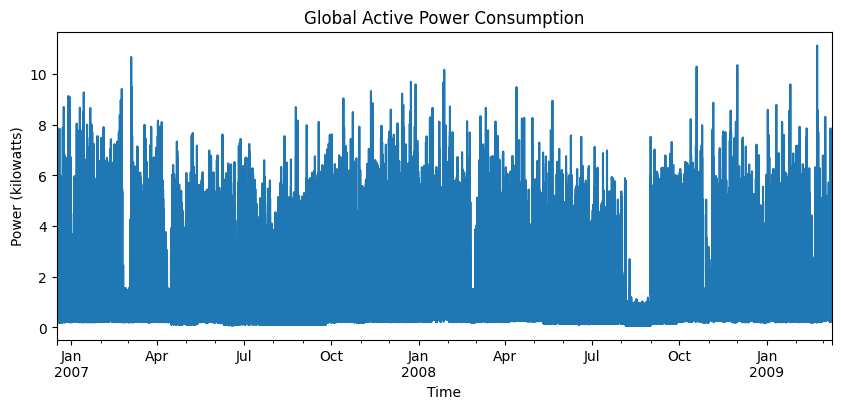

In [ ]:
data[['Date', 'Time']].isnull().sum()
data['Datetime'] = pd.to_datetime(
    data['Date'] + ' ' + data['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

print(data.head())
data.set_index('Datetime', inplace=True)
data['Global_active_power'].plot(figsize=(10,4))
plt.title("Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("Power (kilowatts)")
plt.show()

##Module 2

In [ ]:
print(data.isnull().sum())
print(data.ffill(inplace=True))




Date                        0
Time                        0
Global_active_power      4136
Global_reactive_power    4136
Voltage                  4136
Global_intensity         4136
Sub_metering_1           4136
Sub_metering_2           4136
Sub_metering_3           4136
dtype: int64
None


In [ ]:
Q1 = data['Global_active_power'].quantile(0.25)
Q3 = data['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

data = data[
    (data['Global_active_power'] >= Q1 - 1.5 * IQR) &
    (data['Global_active_power'] <= Q3 + 1.5 * IQR)
]

# Drop non-numeric columns 'Date' and 'Time' before resampling
data_numeric = data.drop(columns=['Date', 'Time'])
print(data_numeric)
hourly_data = data_numeric.resample('h').mean() # Updated: Using 'h' instead of 'H'
print(hourly_data)
daily_data = data_numeric.resample('D').mean()
print(daily_data)

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:39:00                3.384                  0.282   237.14   
2006-12-16 17:40:00                3.270                  0.152   236.73   
2006-12-16 17:41:00                3.430                  0.156   237.06   
2006-12-16 17:42:00                3.266                  0.000   237.13   
2006-12-16 17:49:00                3.248                  0.000   236.66   
...                                  ...                    ...      ...   
2009-03-10 05:58:00                0.382                  0.100   244.08   
2009-03-10 05:59:00                0.380                  0.102   244.55   
2009-03-10 06:00:00                0.380                  0.102   244.53   
2009-03-10 06:01:00                0.376                  0.100   244.19   
2009-03-10 06:02:00                0.374                  0.098   243.39   

           

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
hourly_data[['Voltage']] = scaler.fit_transform(
    hourly_data[['Voltage']]
)

print(hourly_data.head())

                     Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:00:00             3.153636               0.058909  0.400187   
2006-12-16 18:00:00             2.712000               0.070250  0.372466   
2006-12-16 19:00:00             3.358314               0.081765  0.280817   
2006-12-16 20:00:00             3.257263               0.071123  0.310519   
2006-12-16 21:00:00             2.970960               0.058560  0.440023   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         13.290909             0.0        0.000000   
2006-12-16 18:00:00         11.593750             0.0        2.062500   
2006-12-16 19:00:00         14.329412             0.0        1.039216   
2006-12-16 20:00:00         13.877193             0.0        0.000000   
2006-12-16 21:00:00   

In [ ]:
train_size = int(len(hourly_data) * 0.7)
val_size = int(len(hourly_data) * 0.15)

train = hourly_data[:train_size]
val = hourly_data[train_size:train_size + val_size]
test = hourly_data[train_size + val_size:]

print("Train size:", train.shape)
print("Validation size:", val.shape)
print("Test size:", test.shape)


Train size: (13685, 7)
Validation size: (2932, 7)
Test size: (2933, 7)


##Module 3


In [ ]:
# Time-based features
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day'] = hourly_data.index.day
hourly_data['dayofweek'] = hourly_data.index.dayofweek
hourly_data['month'] = hourly_data.index.month

print(hourly_data.head())


                     Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:00:00             3.153636               0.058909  0.400187   
2006-12-16 18:00:00             2.712000               0.070250  0.372466   
2006-12-16 19:00:00             3.358314               0.081765  0.280817   
2006-12-16 20:00:00             3.257263               0.071123  0.310519   
2006-12-16 21:00:00             2.970960               0.058560  0.440023   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         13.290909             0.0        0.000000   
2006-12-16 18:00:00         11.593750             0.0        2.062500   
2006-12-16 19:00:00         14.329412             0.0        1.039216   
2006-12-16 20:00:00         13.877193             0.0        0.000000   
2006-12-16 21:00:00   

In [ ]:
# Aggregate device-level consumption
hourly_data['total_sub_metering'] = (
    hourly_data['Sub_metering_1'] +
    hourly_data['Sub_metering_2'] +
    hourly_data['Sub_metering_3']
)

print(hourly_data[['total_sub_metering']].head())


                     total_sub_metering
Datetime                               
2006-12-16 17:00:00           17.090909
2006-12-16 18:00:00           19.093750
2006-12-16 19:00:00           17.705882
2006-12-16 20:00:00           16.771930
2006-12-16 21:00:00           17.520000


In [ ]:
# Lag feature (previous hour power usage)
hourly_data['lag_1'] = hourly_data['Global_active_power'].shift(1)
hourly_data['lag_24'] = hourly_data['Global_active_power'].shift(24)

print(hourly_data[['Global_active_power', 'lag_1', 'lag_24']].head(30))


                     Global_active_power     lag_1    lag_24
Datetime                                                    
2006-12-16 17:00:00             3.153636       NaN       NaN
2006-12-16 18:00:00             2.712000  3.153636       NaN
2006-12-16 19:00:00             3.358314  2.712000       NaN
2006-12-16 20:00:00             3.257263  3.358314       NaN
2006-12-16 21:00:00             2.970960  3.257263       NaN
2006-12-16 22:00:00             2.200133  2.970960       NaN
2006-12-16 23:00:00             1.995345  2.200133       NaN
2006-12-17 00:00:00             1.882467  1.995345       NaN
2006-12-17 01:00:00             2.253357  1.882467       NaN
2006-12-17 02:00:00             1.587267  2.253357       NaN
2006-12-17 03:00:00             1.662200  1.587267       NaN
2006-12-17 04:00:00             2.046113  1.662200       NaN
2006-12-17 05:00:00             1.971492  2.046113       NaN
2006-12-17 06:00:00             1.303300  1.971492       NaN
2006-12-17 07:00:00     

In [ ]:
# Moving averages
hourly_data['rolling_mean_3'] = hourly_data['Global_active_power'].rolling(window=3).mean()
hourly_data['rolling_mean_24'] = hourly_data['Global_active_power'].rolling(window=24).mean()

print(hourly_data[['rolling_mean_3', 'rolling_mean_24']].head(30))


                     rolling_mean_3  rolling_mean_24
Datetime                                            
2006-12-16 17:00:00             NaN              NaN
2006-12-16 18:00:00             NaN              NaN
2006-12-16 19:00:00        3.074650              NaN
2006-12-16 20:00:00        3.109192              NaN
2006-12-16 21:00:00        3.195512              NaN
2006-12-16 22:00:00        2.809452              NaN
2006-12-16 23:00:00        2.388813              NaN
2006-12-17 00:00:00        2.025982              NaN
2006-12-17 01:00:00        2.043723              NaN
2006-12-17 02:00:00        1.907697              NaN
2006-12-17 03:00:00        1.834275              NaN
2006-12-17 04:00:00        1.765193              NaN
2006-12-17 05:00:00        1.893268              NaN
2006-12-17 06:00:00        1.773635              NaN
2006-12-17 07:00:00        1.631608              NaN
2006-12-17 08:00:00        1.604633              NaN
2006-12-17 09:00:00        1.815960           

In [ ]:
# Drop rows with NaN values
final_data = hourly_data.dropna()

print(final_data.shape)
final_data.head()


(18981, 16)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,dayofweek,month,total_sub_metering,lag_1,lag_24,rolling_mean_3,rolling_mean_24
Datetime,,,,,,,,,,,,,,,,
2006-12-17 17:00:00,3.295171,0.142537,0.318138,14.039024,0.0,0.219512,16.804878,17,17,6,12,17.024390,2.906426,3.153636,2.899852,2.216048
2006-12-17 18:00:00,3.317263,0.103579,0.376986,14.010526,0.0,0.000000,17.052632,18,17,6,12,17.052632,3.295171,2.712000,3.172953,2.241267
2006-12-17 19:00:00,2.642596,0.238426,0.288938,11.353191,0.0,0.595745,16.680851,19,17,6,12,17.276596,3.317263,3.358314,3.085010,2.211446
2006-12-17 20:00:00,2.953643,0.211857,0.370349,12.571429,0.0,0.928571,16.964286,20,17,6,12,17.892857,2.642596,3.257263,2.971167,2.198795
2006-12-17 21:00:00,3.005860,0.268667,0.511051,12.564912,0.0,1.192982,17.508772,21,17,6,12,18.701754,2.953643,2.970960,2.867366,2.200249


##Module 4

In [ ]:
from sklearn.model_selection import train_test_split

# Target variable
y = final_data['Global_active_power']

# Features (drop target)
X = final_data.drop(columns=['Global_active_power'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (15184, 15)
Test size: (3797, 15)


In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize model
model = LinearRegression()

# Train model
model.fit(X_train, y_train)

print("Model training completed")


Model training completed


In [ ]:
# Predictions
y_pred = model.predict(X_test)

print("Sample predictions:", y_pred[:5])


Sample predictions: [2.02436773 2.22772493 0.61131313 0.3299492  0.369705  ]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.015619353111517605
RMSE: 0.020501685608939276


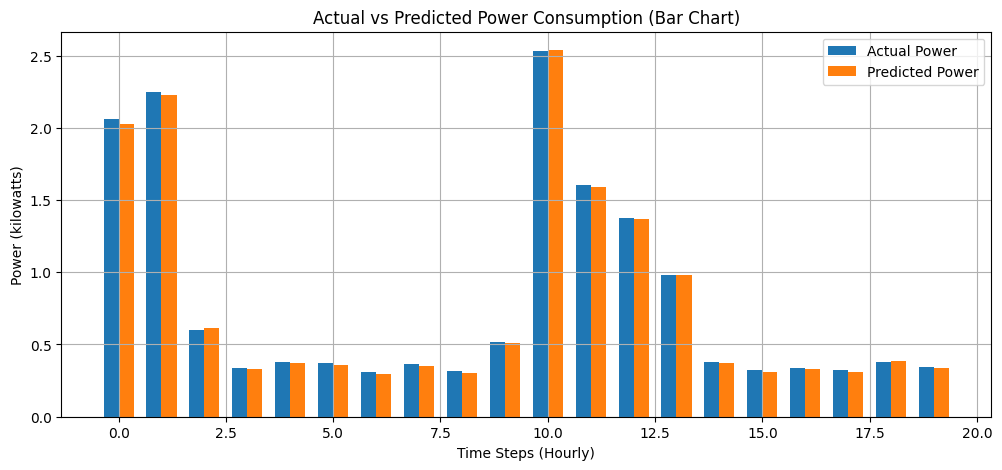

In [ ]:
# Select small sample (first 20 points)
sample_size = 20
actual_sample = y_test.values[:sample_size]
pred_sample = y_pred[:sample_size]

x = np.arange(sample_size)
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, actual_sample, width, label='Actual Power')
plt.bar(x + width/2, pred_sample, width, label='Predicted Power')

plt.xlabel("Time Steps (Hourly)")
plt.ylabel("Power (kilowatts)")
plt.title("Actual vs Predicted Power Consumption (Bar Chart)")
plt.legend()
plt.grid(True)
plt.show()
